# Variational Quantum Optimization (VQO) of CHSH Violation

This notebook demonstrates how quantum machine learning can be applied to train a quantum circuit to violate the Bell inequality.

<div>
<img src="img/chsh-scenario.png" width="200"/>
</div>
 
* $x,y\in\{0,1\}$ and $a,b\in\{-1,1\}$.
* Local qubit measurements $\Pi_a^x$ and $\Pi_b^y$ are projective.
* State preparation $\Phi^{AB}$ is a static, bipartite quantum state.

$$
I_{CHSH} = \sum_{x,y\in\{0,1\}} (-1)^{x\wedge y}\langle A_xB_y\rangle\leq 2
$$

**Goal:** Find state preparation and measurements that maximally violate the CHSH inequality.

## Requirements

This code requires the `pennylane` and `matplotlib` python libraries.

In [1]:
# quantum machine learning framework
import pennylane as qml

# numpy extension for pennylane
from pennylane import numpy as np

# plotting utility
import matplotlib.pyplot as plt

## CHSH Ansatz

We consider a simple ansatz circuit $U_{CHSH}^{AB}(\vec{\theta})$ for the CHSH scenario.

<div>
<img src="img\chsh_ansatz.png" width="300"/>
</div>

* **State Preparation:** local qubit rotations about the $y$-axis followed by a CNOT gate. Can prepare any pure state in the Bell basis or omputational basis.
* **Measurement:** The computational basis is rotated about the $y$-axis allowing any projective measurement in the $x$-$z$-plane to be realized.
 
$$
\begin{align}
    U^{AB}_{CHSH}(\vec{\theta})|00\rangle^{AB} &= \left(R^A_y(\theta_2)\otimes R^B_y(\theta_3)\right)U^{AB}_{CNOT}\left(R^A_y(\theta_0)\otimes R^B_y(\theta_1)\right)|00\rangle^{AB} \\
    &= \left(R^A_y(\theta_2)\otimes R^B_y(\theta_3)\right)|\psi(\theta_0,\theta_1)\rangle^{AB} \\
    &= |\psi_{CHSH}(\vec{\theta})\rangle^{AB}\\
\end{align}
$$


This ansatz parameterizes real-valued states and measurements, but is sufficient to find nonlocal behaviors.


In [2]:
def chsh_ansatz(settings, wires):
    # state prepartion
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])
    
    # measurement basis rotations
    qml.RY(settings[2], wires=wires[0])
    qml.RY(settings[3], wires=wires[1])

## Ansatz Parameterization

The CHSH scenario has a static state preparation and two inputs, $x,y \in \{0,1\}$ that select local measurement bases.

We organize our settings into preparation and measurement settings:

$$
\vec{\theta} = (\{\theta\}^P, \{\theta\}^M) = \left([\theta_0,\theta_1], \begin{bmatrix}
    \theta_2^{x=0} & \theta_2^{x=1} \\ \theta_3^{x=0} & \theta_3^{x=1}
\end{bmatrix}\right)
$$

while $\vec{\theta}_{x,y} = [\theta_0, \theta_1, \theta^x_2, \theta^y_3]$.
We now write a function create randomized initial parameters.

In [3]:
def random_scenario_settings():
    preparation_settings = np.random.random(2)
    measurement_settings = np.random.random((2,2))
    
    return [preparation_settings, measurement_settings]

random_scenario_settings()

[tensor([0.37895832, 0.00818022], requires_grad=True),
 tensor([[0.14476653, 0.61528113],
         [0.4289039 , 0.1094481 ]], requires_grad=True)]

## PennyLane Devices

PennyLane uses a `Device` class to model quantum hardware.
* Devices can be either a classical simulator or quantum hardware.
* Devices can run locally on your laptop or executed remotely by a third party.

For this demo, we use the default state-vector simulator. 
We only need two qubits (`wires`).
This device will numerically evaluate the quantum circuit expectations rather than constructing a distribution through sampling.

In [4]:
chsh_dev = qml.device("default.qubit", wires=[0,1])

## PennyLane QNodes

A quantum node (`QNode`) class describes a quantum circuit run by a particular device.
The `QNode` is a differentiable function with customizeable optimizer interfaces and gradient methods.
A qnode

The `@qml.qnode` decorator specifies that the `chsh_dev` device is used to execute the `chsh_correlator` function.

The CHSH correlator extends our ansatz with a joint observable expectation

$$
\begin{align}
    \langle A_xB_y\rangle(\vec{\theta}_{x,y}) &= \langle\psi(\theta_0,\theta_1)|A_x(\theta_2)B_y(\theta_3)|\psi(\theta_0,\theta_1)\rangle\\
        &= \sum_{i,j\in\{0,1\}}(-1)^{i\oplus j}\left|\langle ij|R^A_y(\theta_2)\otimes R^B_y(\theta_3)|\psi(\theta_0,\theta_1)\rangle^{AB}\right|^2 \\
        &= \sum_{i,j\in\{0,1\}}(-1)^{i\oplus j}\left|\langle ij|U^{AB}_{CHSH}(\vec{\theta}_{x,y})|00\rangle^{AB}\right|^2 \\
\end{align}
$$

Here $|ij\rangle$ is the computational basis. The labels $x$ and $y$ on the observables correspond to different parameter vectors $\vec{\theta}_{x,y}$ 

In [5]:
@qml.qnode(chsh_dev)
def chsh_correlator(settings): 
    wires = chsh_dev.wires
    chsh_ansatz(settings, wires)
    
    # computational basis measurement
    return qml.expval(
        qml.PauliZ(wires[0]) @ qml.PauliZ(wires[1])
    )

### Drawing the Ansatz Circuit

In [6]:
chsh_correlator([0,0,0,0])
print(chsh_correlator.draw())

 0: ──RY(0)──╭C──RY(0)──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──RY(0)──╰X──RY(0)──╰┤ ⟨Z ⊗ Z⟩ 



### Evaluating a QNode

In [7]:
print("00 prep and ZZ meas : ", chsh_correlator([0,0,0,0]))

00 prep and ZZ meas :  1.0


In [8]:
print("01 prep and ZZ meas : ", chsh_correlator([0,np.pi,0,0]))

01 prep and ZZ meas :  -1.0


In [9]:
print("00 prep and XX meas : ", chsh_correlator([0,0,-np.pi/2,-np.pi/2]))

00 prep and XX meas :  0.0


In [10]:
print("bell prep and ZZ meas : ", chsh_correlator([np.pi/2,0,0,0]))

bell prep and ZZ meas :  1.0


In [11]:
print("bell prep and XX meas : ", chsh_correlator([np.pi/2,0,-np.pi/2,-np.pi/2]))

bell prep and XX meas :  0.9999999999999998


In [12]:
print("bell prep and ZX meas : ", chsh_correlator([np.pi/2,0,0,-np.pi/2]))

bell prep and ZX meas :  2.220446049250313e-16


## The CHSH Cost Function

The CHSH inequality is expressed as:

$$
I_{CHSH}(\vec{\theta}) = \sum_{x,y\in\{0,1\}} (-1)^{x\wedge y}\langle A_xB_y\rangle(\vec{\theta}_{x,y})
$$

The corresponding cost function is expressed as:


$$
\text{Cost}(\vec{\theta}) = - I_{CHSH}(\vec{\theta})
$$



In [13]:
def chsh_cost(scenario_settings):

    score = 0
    for x, y in [[0,0],[0,1],[1,0],[1,1]]:
        # construct the settings for inputs `x` and `y`
        qnode_settings = [
            *scenario_settings[0],
            scenario_settings[1][0,x],
            scenario_settings[1][1,y]
        ]
        
        # evaluate the `chsh_correlator` qnode
        score += (-1)**(x * y) * chsh_correlator(qnode_settings)
        
    # invert score because cost is minimized
    return -(score)

## Gradient Descent

Our goal is to find $\arg\min_{\vec{\theta}} \text{Cost}(\vec{\theta})$ using automatic differentiation and gradient descent.
This minimization problem is equivalent to maximizing the CHSH violation.

$$
\begin{align}
    \vec{\theta}' &= \vec{\theta} - \eta\nabla_{\vec{\theta}}\text{Cost}(\vec{\theta}) \\
    &= \vec{\theta} + \eta\nabla_{\vec{\theta}}I_{CHSH}(\vec{\theta}) 
\end{align}
$$

PennyLane handles the automatic differentiation of the `chsh_correlator` QNode.
We add a loop that iteratively computes the gradient and updates the settings. 
Each step in this training procedure is called an epoch.

In [14]:
def gradient_descent(cost, settings, step_size=0.1, num_steps=20):
    # optimizer work horse
    opt = qml.GradientDescentOptimizer(stepsize=step_size)
        
    scores = []
    settings_list = []  
    for i in range(num_steps):
        # log data
        score = -(cost(settings))       
        scores.append(score)
        settings_list.append(settings)
                
        # print progress
        if i % 5 == 0:
            print("iteration : ", i, ", score : ", score)
        
        # update settings using gradient evaluated at `settings`
        settings = opt.step(cost, settings)
    
    # log data for final score and settings
    final_score = -(cost(settings))
    scores.append(final_score)
    settings_list.append(settings)
    
    # find the maximum value and optimal settings
    max_score = max(scores)
    max_id = scores.index(max_score)
    opt_settings = settings_list[max_id]
                
    return {
        "max_score" : max_score,
        "opt_settings" : opt_settings,
        "max_id" : max_id,
        "samples" : range(num_steps + 1),
        "scores" : scores,
        "settings" : settings_list
    }

## VQO of a Maximally Nonlocal CHSH Protocol

In [15]:
%%time

# initialize random parameters
init_settings = random_scenario_settings()
print("initial settings :\n", init_settings, "\n")

opt_dict = gradient_descent(chsh_cost, init_settings, step_size=0.5);

print("\nmax score : ", opt_dict["max_score"])
print("optimal settings : ", opt_dict["opt_settings"], "\n")
print("theoretical max : ", 2 * np.sqrt(2), "\n")

initial settings :
 [tensor([0.96123244, 0.55235034], requires_grad=True), tensor([[0.37514297, 0.50044924],
        [0.29133242, 0.46641267]], requires_grad=True)] 

iteration :  0 , score :  1.5088222141327297
iteration :  5 , score :  2.010436716885594
iteration :  10 , score :  2.5808417015638088
iteration :  15 , score :  2.8284193404598703

max score :  2.828427124707118
optimal settings :  [array([ 1.57079231e+00, -1.06968197e-06]), array([[ 0.71599797, -0.85479238],
       [-0.06939297,  1.50139766]])] 

theoretical max :  2.8284271247461903 

CPU times: user 436 ms, sys: 21.8 ms, total: 458 ms
Wall time: 448 ms


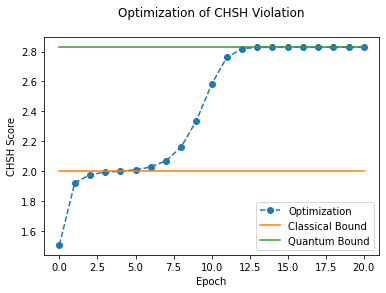

In [16]:
plt.plot(opt_dict["samples"], opt_dict["scores"], "o--", label="Optimization")
plt.plot(opt_dict["samples"], [2]*len(opt_dict["samples"]), label="Classical Bound")
plt.plot(opt_dict["samples"], [2*np.sqrt(2)]*len(opt_dict["samples"]), label="Quantum Bound")

plt.title("Optimization of CHSH Violation\n")
plt.ylabel("CHSH Score")
plt.xlabel("Epoch")
plt.legend()

plt.show()